In [52]:
from scipy.io import loadmat

loaded_dataset = loadmat("dataset_liver_bmodes_steatosis_assessment_IJCARS.mat")

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import joblib

In [54]:
def assign_grade(fat_percent):
    if fat_percent < 5:
        return 0
    elif 5 <= fat_percent < 34:
        return 1
    elif 34 <= fat_percent < 66:
        return 2
    else:
        return 3

In [55]:
def enhance_image(image):
    image = np.uint8(image)
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)

    # Apply adaptive histogram equalization (CLAHE) to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(scaled_image.astype(np.uint8))

    # Apply bilateral filtering for noise reduction while preserving edges
    enhanced_image = cv2.bilateralFilter(enhanced_image, 15, 50, 50)

    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))

    wiener_image = cv2.blur(sharpened_image, (3, 3))

    return wiener_image

## Setting up dataset and creating image files

In [4]:
data = loaded_dataset["data"]
data_records = {"id": [], "fat": [], "class": [], "images": [], "grade": []}

for record in range(55):
    id_ = data["id"][0][record][0][0]
    fat = data["fat"][0][record][0][0]
    cat = data["class"][0][record][0][0]
    imgs = data["images"][0][record]

    for index, im in enumerate(imgs):
        filename = f"{id_}_{cat}_{fat}_{index}.jpg"
        enhanced_im = enhance_image(im.astype(np.uint8))

        # cropping the image for region of interest
        roi_im = enhanced_im[300:700, 170:800]

        # to save images, uncomment the lines below

        # Check if the directories exist, and create them if they don't
        # for dir_name in ["og", "enh", "roi"]:
        #     if not os.path.exists(dir_name):
        #         os.makedirs(dir_name)

        # use "gray" instead of "grey" if there is an error regarding colours

        # plt.imsave(f"og/{filename}", im.astype(np.uint8), cmap="grey")
        # plt.imsave(f"enh/{filename}", enhanced_im, cmap="grey")
        # plt.imsave(f"roi/{filename}", roi_im, cmap="grey")
        # roi_im = roi_im.astype(np.uint8)

        data_records["id"].append(id_)
        data_records["fat"].append(fat)
        data_records["class"].append(cat)
        data_records["images"].append(roi_im)
        # data_records["images"].append(enhanced_im)
        data_records["grade"].append(assign_grade(fat))
    joblib.dump(data_records, 'data_records.pkl')


print(f"Dimension of original image: {enhanced_im.shape}")
print(f"Dimension of region of interest: {roi_im.shape}")

data_records = joblib.load('data_records.pkl')
df = pd.DataFrame(data_records)

Dimension of original image: (868, 1272)
Dimension of region of interest: (400, 630)


In [56]:
data_records = joblib.load('data_records.pkl')
df = pd.DataFrame(data_records)

Reduced area by 77.19%

In [6]:
class_counts = df["class"].value_counts().sort_index()

# Print each class and its count
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

0: 170
1: 380


Class imbalance - 0:1 :~: 1:2

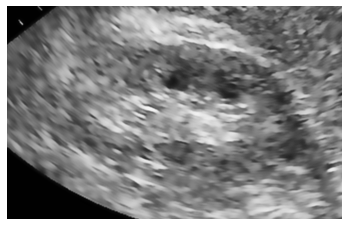

In [6]:
# Generate a random index
random_index = np.random.randint(0, len(data_records["images"]))

# Plot the random image
plt.imshow(data_records["images"][random_index], cmap="gray")

plt.axis("off")
plt.show()

In [7]:
import os
import random


# Get list of image filenames in the directory
directory = "og/"
image_filenames = os.listdir(directory)

random_image_filename = random.choice(image_filenames)
random_image_path = os.path.join(directory, random_image_filename)
random_image = plt.imread(random_image_path)
plt.imsave("ultrasound_scan.jpg", random_image, cmap="gray")


### GLCM features

In [57]:
from skimage.feature import graycomatrix, graycoprops


# Define function to compute GLCM features for a single image
def compute_glcm_features(image):

    image = image.astype(np.uint8)
    distances = [1, 2, 3]  # Define distances for GLCM computation
    angles = [
        0,
        np.pi / 4,
        np.pi / 2,
        3 * np.pi / 4,
    ]  # Define angles for GLCM computation
    glcm = graycomatrix(
        image, distances=distances, angles=angles, symmetric=True, normed=True
    )
    # print(glcm.shape)
    # Compute GLCM properties
    contrast = graycoprops(glcm, "contrast").ravel()
    energy = graycoprops(glcm, "energy").ravel()
    homogeneity = graycoprops(glcm, "homogeneity").ravel()
    correlation = graycoprops(glcm, "correlation").ravel()

    # Concatenate GLCM features
    glcm_features = np.concatenate([contrast, energy, homogeneity, correlation])
    return glcm_features

In [9]:
images = df["images"].values[1]

# glcm_features = [compute_glcm_features(image.astype(np.uint8)) for image in images]
glcm_features = compute_glcm_features(images.astype(np.uint8))

print(f"Dimension of feature matrix of one image: {glcm_features.shape}")

Dimension of feature matrix of one image: (48,)


The other options in GLCM is dissimilarity and ASM

Here, we are trying to find the similarity and is handled by correlation. Dissimilarity often would produce noise or irrelevant information.
ASM at times is not often used for finding subtle differences. we concentrate on the subtle details for detecting liver steatosis.
Since these two contribute less to the model's performance, and it would **take more time to compute** these, it was decided that these features can be omitted. Even after adding them performance did not seem to improve, rather got worse.

Different angles and distance were also tried, to finally settle on these.

Each element in the `glcm_features` is the value calculated using a distance and an angle: this gives the relation between the pixels at the givn angle and distance

In [58]:
images = df["images"].values

print(
    f"Dimension of glcm feature of one image: {compute_glcm_features(images[0].astype(np.uint8)).shape}"
)
# Compute GLCM features for each image
glcm_features = [compute_glcm_features(image.astype(np.uint8)) for image in images]

# Concatenate GLCM features into a feature matrix
feature_matrix = np.array(glcm_features)
print(f"Dimension of feature matrix: {feature_matrix.shape}")

Dimension of glcm feature of one image: (48,)
Dimension of feature matrix: (550, 48)


## GLCM Theory
### Co-occurence matrix calculation

Dimension of `glcm` is (256, 256, 3, 4) = (number of grey levels, n of grey levels, n of distances, n of angles)


There are 256 grey levels because the range of greyscale is 0-256. (it is set in the `levels` argument in graycomatrix fn. The `levels` param should be greater than the max grey value)

A co-occ matrix is calculated for one (dist, angle) pair. So `glcm` is a collection of all 12 matrices for each combination of angles and dist (4*3). Each co-occ matrix is of size 255x255

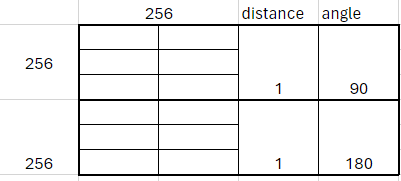

### Feature Calculation
Then the 4 properties are calculated: energy, contrast, homogeniety, similarity.

Each property calculates one value per matrix. So there will be 12 values (because of 12 matrices) for one property.

Since there are 4 properties, there will be 12*4=48 values for an image (as a vector)

So, `glcm_features` is of size (48,)

`feature_matrix` is concatenation of `glcm_features` of each image. Since we have 550 images, the dimension is (550, 48)

Now, we have come down from size of (550, 868, 1272) for original image to (550, 400, 630) for region of interest to (550, 48)


In [59]:
y = df["grade"]

In [60]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [61]:
def display_results(metrics):
    
    print("Mean Accuracy:", metrics["mean_accuracy"])
    print("Mean ROC-AUC Score:", metrics["mean_auc"])
    print("Mean Confusion Matrix:\n", metrics["mean_conf_matrix"])
    print("Mean Classification Report:\n", metrics["classification_report"])

    class_names = ["No Disease", "Disease"]
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        metrics["mean_conf_matrix"],
        annot=True,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [48]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

def train_rfc_with_pca(X, y, pca, test_size=0.2, random_state=42):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Initialize a Random Forest classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=random_state,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        criterion="entropy",
    )

    # Train the classifier
    clf.fit(X_train_pca, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test_pca)

    # Calculate various metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, clf.predict_proba(X_test_pca), multi_class='ovr', average='macro')  # For multiclass ROC-AUC
    conf_matrix = confusion_matrix(y_test, y_pred)
    cls_report = classification_report(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")


    display_conf_matrix(conf_matrix)
    # Display metrics
    print("Accuracy:", accuracy)
    print("Precision:", prec)
    print("F1: ", f1)
    print("Recall:", recall)

    print("ROC-AUC Score:", auc)
    print("Classification Report:")
    print(cls_report)

    return clf


In [62]:
def display_conf_matrix(conf_matrix):
    # Plot the confusion matrix
    class_names = ["Grade 1", "Grade 2", "Grade 3", "Grade 4"]
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

PCA(MLE) gives better accuracy and stuff that any other methods

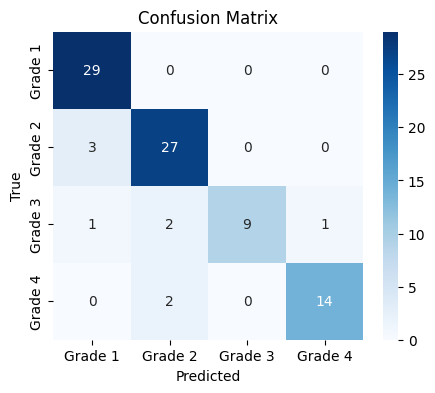

Accuracy: 0.8977272727272727
Precision: 0.9039456145027992
F1:  0.8951634755322079
Recall: 0.8977272727272727
ROC-AUC Score: 0.9786048240207905
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        29
           1       0.87      0.90      0.89        30
           2       1.00      0.69      0.82        13
           3       0.93      0.88      0.90        16

    accuracy                           0.90        88
   macro avg       0.92      0.87      0.89        88
weighted avg       0.90      0.90      0.90        88



In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, y, test_size=0.2, random_state=42, stratify=y
)
pca = PCA(n_components="mle")
model = train_rfc_with_pca(X_train, y_train, pca)


Test Accuracy: 0.8909090909090909


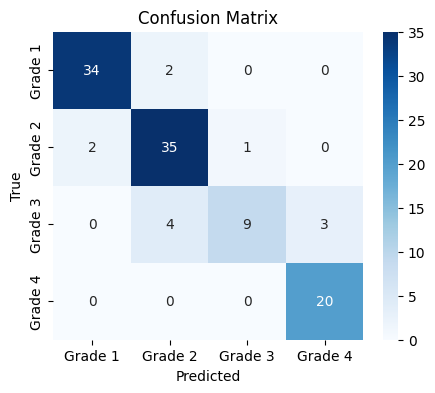

In [23]:
pca.fit_transform(X_train)
X_test = pca.transform(X_test)
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

display_conf_matrix(conf_matrix)

In [28]:
#joblib library, which provides functions for saving and loading Python objects to and from disk.
import joblib

# Save the trained model and PCA preprocessor
joblib.dump(model, r"..\models\mc_trained_model.pkl")
joblib.dump(pca, r"..\models\mc_pca_preprocessor.pkl")

['..\\models\\mc_pca_preprocessor.pkl']

In [29]:

loaded_model = joblib.load(r"..\models\trained_model.pkl")
loaded_pca = joblib.load(r"..\models\pca_preprocessor.pkl")

ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

In [27]:
def preprocess_img(image_data, l_pca=pca):
    input_img = cv2.imread(image_data, cv2.CV_8UC1)
    enhanced_img = enhance_image(input_img)
    roi_img = enhanced_img[300:700, 170:800]

    glcm_features = compute_glcm_features(roi_img)
    pca_features = l_pca.transform([glcm_features])

    return pca_features

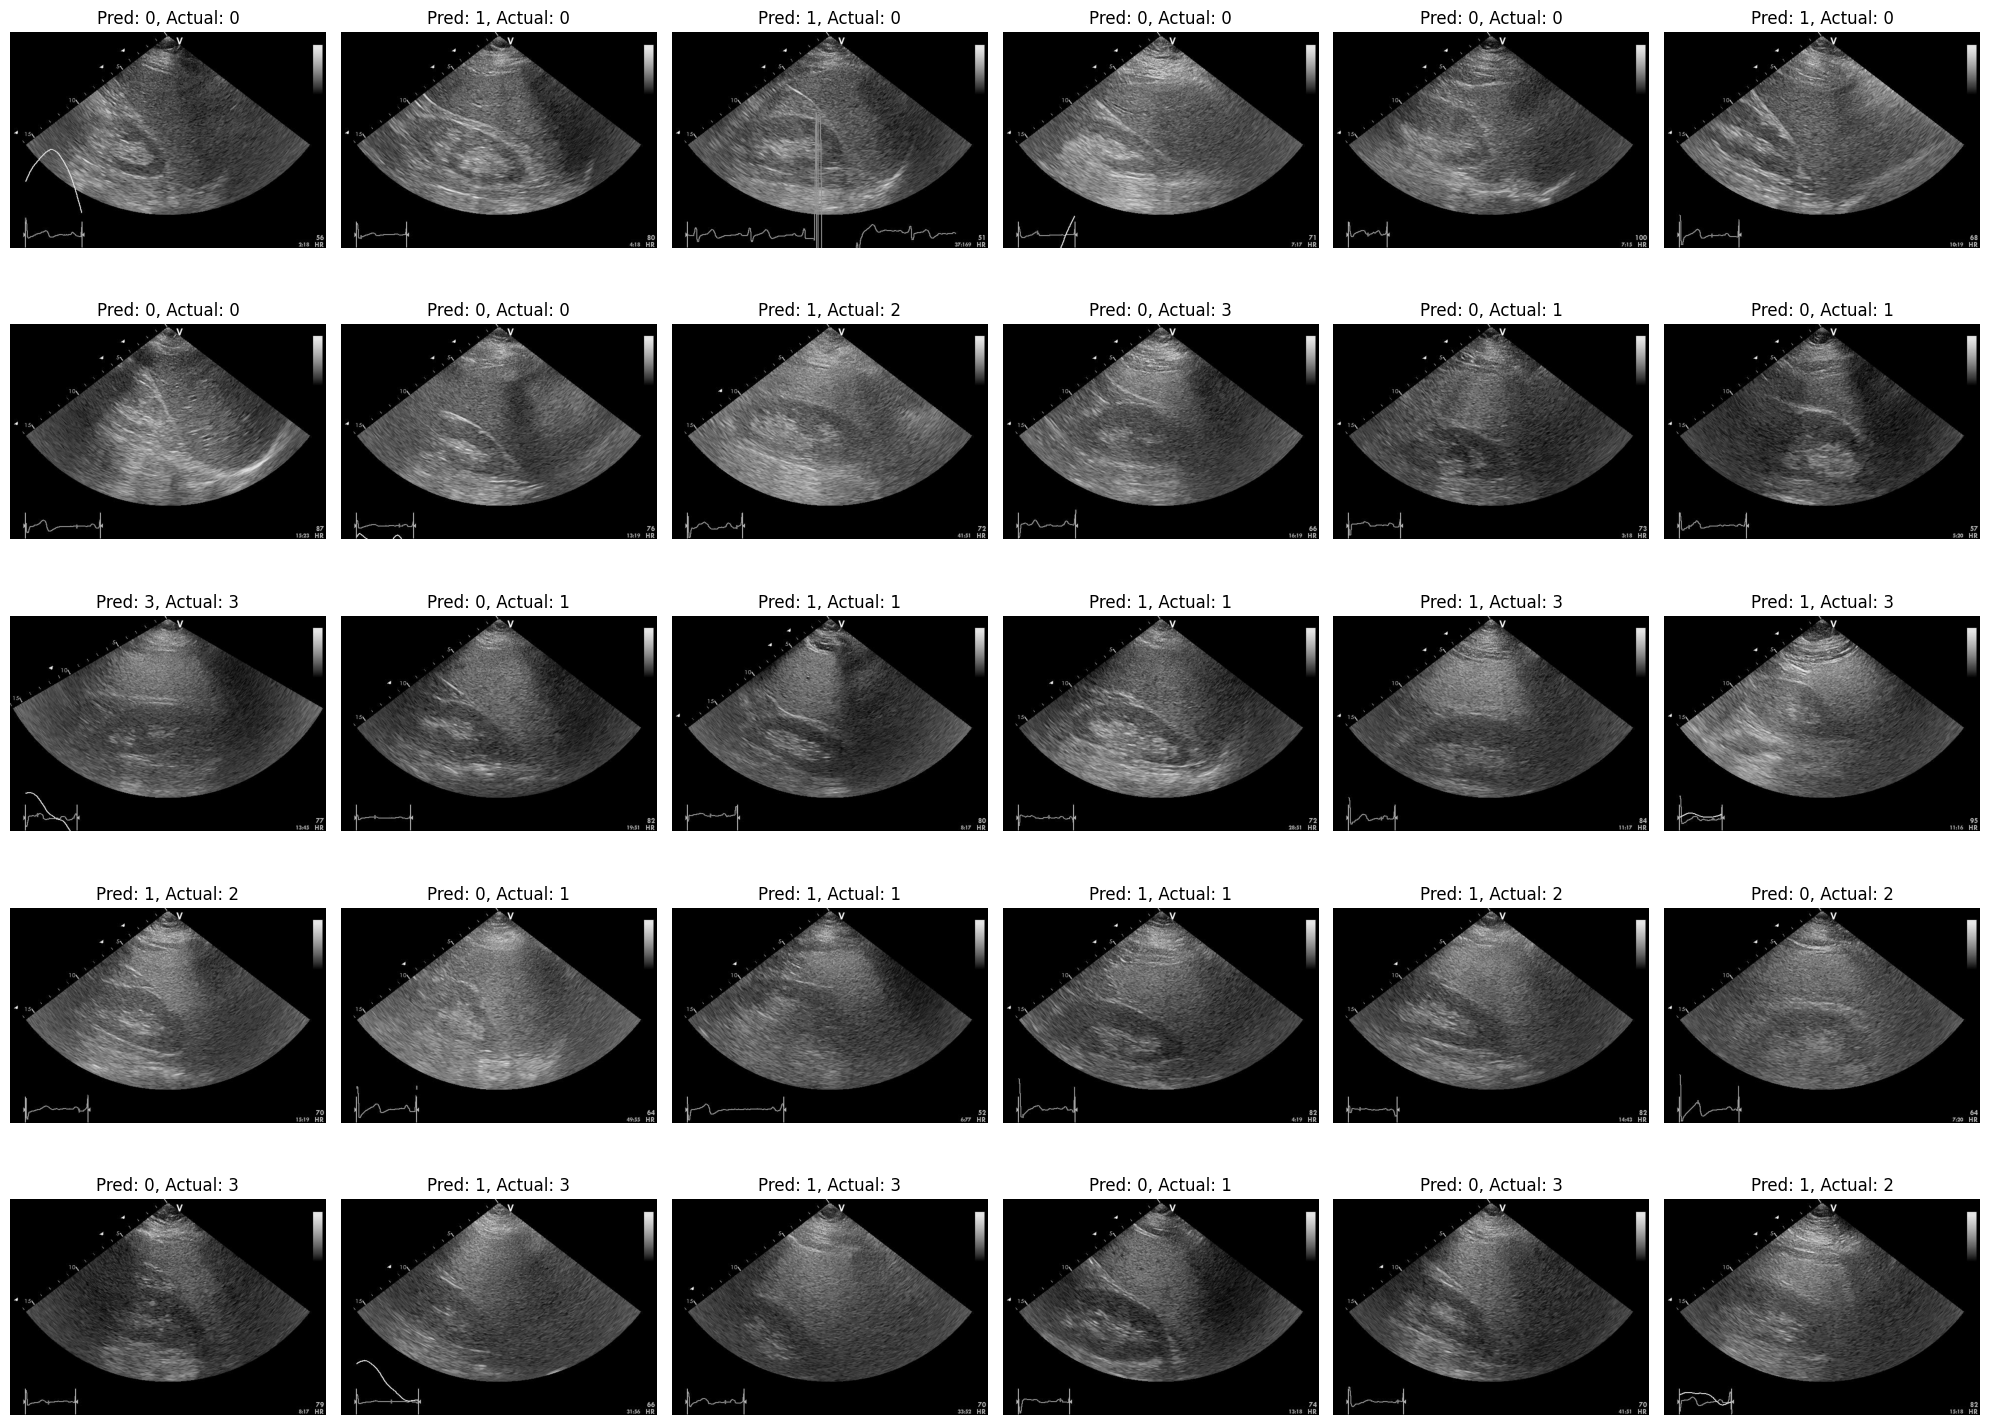

In [42]:
import matplotlib.pyplot as plt
import os

directory = r"og"


def get_actual_value(filename):
    # print(filename)
    return assign_grade(int(filename.split("_")[2]))


plt.figure(figsize=(20, 15))

image_count = 0

for idx, filename in enumerate(os.listdir(directory)[0:330:11], start=1):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        new_features_pca = preprocess_img(filepath)
        prediction = model.predict(new_features_pca)
        actual_value = get_actual_value(filename)

        img = plt.imread(filepath)
        plt.subplot(5, 6, idx)
        plt.imshow(img)
        plt.title(f"Pred: {prediction[0]}, Actual: {actual_value}")
        plt.axis("off")

        image_count += 1

plt.tight_layout()
plt.show()

Accuracy: 0.6545454545454545
Precision:  0.5640783734040549
F1 Score:  0.60548313027179
Recall:  0.6545454545454545
ROC-AUC Score: 0.8373601000694109
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82        46
           1       0.51      0.62      0.56        34
           2       0.00      0.00      0.00        16
           3       0.61      0.79      0.69        14

    accuracy                           0.65       110
   macro avg       0.48      0.57      0.52       110
weighted avg       0.56      0.65      0.61       110



c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

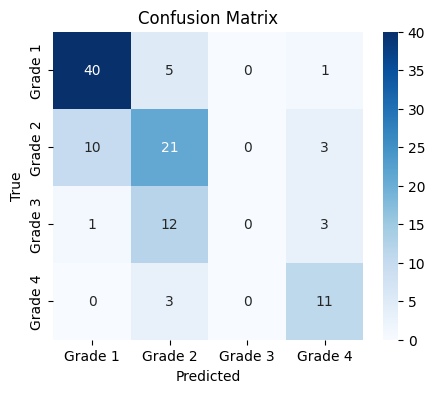

In [64]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
import numpy as np

# Update PCA with a fixed number of components (you can adjust as needed)
pca = PCA(n_components="mle")

# Set up SVC for multi-class classification with probability estimates for ROC-AUC calculation
clf = SVC(decision_function_shape='ovr', probability=True)

# Split the dataset into training and testing sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, y, test_size=0.2, random_state=42)

# Apply PCA to the training and test data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the classifier
clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate ROC-AUC score for multi-class classification
y_proba = clf.predict_proba(X_test_pca)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

precision = precision_score(y_test, y_pred, average="weighted")

f1 = f1_score(y_test, y_pred, average="weighted")

recall = recall_score(y_test, y_pred, average="weighted")
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate classification report
cls_report = classification_report(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Precision: ", precision)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("ROC-AUC Score:", auc)
# print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", cls_report)

display_conf_matrix(conf_matrix)


c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

mean_accuracy  0.5890848974419893
best_accuracy 0.6174863387978142
mean_auc 0.8010993429467215
Precision:  0.508953336261826
F1 Score:  0.5648922734491253
Recall:  0.6174863387978142
ROC-AUC Score: 0.8146692241221605
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        60
           1       0.49      0.58      0.53        64
           2       0.00      0.00      0.00        27
           3       0.45      0.67      0.54        33

    accuracy                           0.59       184
   macro avg       0.45      0.52      0.48       184
weighted avg       0.53      0.59      0.55       184



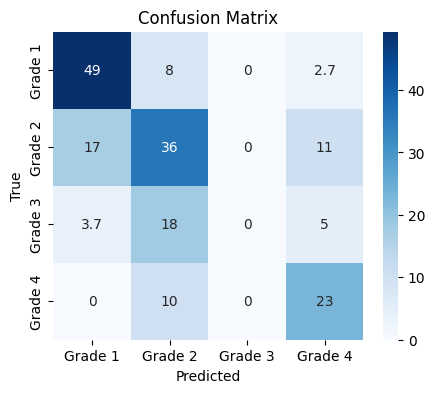

In [66]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

# Update the PCA with appropriate number of components
pca = PCA(n_components="mle")  # Adjust this as needed

# Set up the SVC for multi-class classification
clf = SVC(decision_function_shape='ovr', probability=True)  # Use one-vs-rest and enable probability estimates

# Initialize an array to store accuracy scores and other metrics
accuracy_scores = []
auc_scores = []
conf_matrices = []
precision_scores=[]
f1_scores=[]
recall_scores=[]
classification_reports = []

# Define the number of folds for cross-validation
num_folds = 3
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(feature_matrix, y):
    X_train, X_test = feature_matrix[train_index], feature_matrix[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train the classifier
    clf.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Calculate ROC-AUC score for multi-class classification
    y_proba = clf.predict_proba(X_test_pca)  # Get probability estimates
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')  # Use one-vs-rest for multi-class ROC-AUC
    auc_scores.append(auc)
    
    precision = precision_score(y_test, y_pred, average="weighted")
    precision_scores.append(precision)

    f1 = f1_score(y_test, y_pred, average="weighted")
    f1_scores.append(f1)

    recall = recall_score(y_test, y_pred, average="weighted")
    recall_scores.append(recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)

    # Calculate classification report
    cls_report = classification_report(y_test, y_pred)
    classification_reports.append(cls_report)

# Calculate mean metrics and other details
print('mean_accuracy ', np.mean(accuracy_scores),)
print('best_accuracy', max(accuracy_scores))
print('mean_auc', np.mean(auc_scores))
print("Precision: ", np.mean(precision_scores))
print("F1 Score: ", f1)
print("Recall: ", recall)
print("ROC-AUC Score:", auc)
print("Classification Report:\n", classification_reports[0])


display_conf_matrix(np.mean(conf_matrices, axis=0))

c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

mean_accuracy  0.5909090909090908
best_accuracy 0.6090909090909091
mean_auc 0.8034417514518999
Precision:  0.5100958780873757
F1 Score:  0.533315755077134
Recall:  0.5818181818181818
ROC-AUC Score: 0.819993012679533
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        36
           1       0.47      0.61      0.53        38
           2       0.00      0.00      0.00        16
           3       0.52      0.65      0.58        20

    accuracy                           0.60       110
   macro avg       0.46      0.52      0.48       110
weighted avg       0.53      0.60      0.56       110



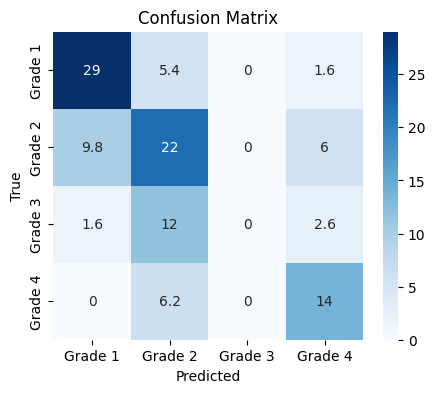

In [67]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

# Update the PCA with appropriate number of components
pca = PCA(n_components="mle")  # Adjust this as needed

# Set up the SVC for multi-class classification
clf = SVC(decision_function_shape='ovr', probability=True)  # Use one-vs-rest and enable probability estimates

# Initialize an array to store accuracy scores and other metrics
accuracy_scores = []
auc_scores = []
conf_matrices = []
precision_scores=[]
f1_scores=[]
recall_scores=[]
classification_reports = []

# Define the number of folds for cross-validation
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(feature_matrix, y):
    X_train, X_test = feature_matrix[train_index], feature_matrix[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train the classifier
    clf.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Calculate ROC-AUC score for multi-class classification
    y_proba = clf.predict_proba(X_test_pca)  # Get probability estimates
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')  # Use one-vs-rest for multi-class ROC-AUC
    auc_scores.append(auc)
    
    precision = precision_score(y_test, y_pred, average="weighted")
    precision_scores.append(precision)

    f1 = f1_score(y_test, y_pred, average="weighted")
    f1_scores.append(f1)

    recall = recall_score(y_test, y_pred, average="weighted")
    recall_scores.append(recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)

    # Calculate classification report
    cls_report = classification_report(y_test, y_pred)
    classification_reports.append(cls_report)

# Calculate mean metrics and other details
print('mean_accuracy ', np.mean(accuracy_scores),)
print('best_accuracy', max(accuracy_scores))
print('mean_auc', np.mean(auc_scores))
print("Precision: ", np.mean(precision_scores))
print("F1 Score: ", f1)
print("Recall: ", recall)
print("ROC-AUC Score:", auc)
print("Classification Report:\n", classification_reports[0])


display_conf_matrix(np.mean(conf_matrices, axis=0))